In [916]:
from imutils.contours import sort_contours
import numpy as np
import pytesseract
import argparse
import imutils
import sys
import cv2
import json
import jsonpickle
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [917]:
#!pip install imutils
#!pip install jsonpickle

In [918]:
#image = cv2.imread("card1_res.png")
image = cv2.imread("card1_res.png")
image = cv2.resize(image, (1000, 450))

In [919]:
def show_image(label,image):
    # Using cv2.imshow() method
    # Displaying the image
#     cv2.imshow(label, image)

#     # waits for user to press any key
#     # (this is necessary to avoid Python kernel form crashing)
#     cv2.waitKey(0)

#     # closing all open windows
#     cv2.destroyAllWindows()
    # call imshow() using plt object
    plt.imshow(image)

    # display that image
    plt.show()

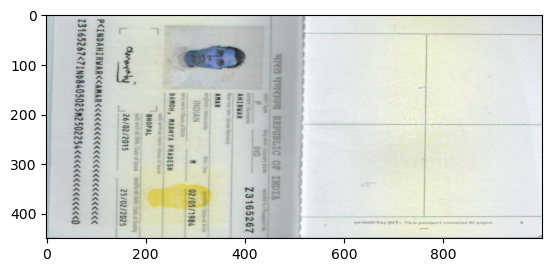

In [920]:
show_image("image",image)

In [921]:
#rot_image = cv2.rotate(image, cv2.ROTATE_180)
#rot_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

In [922]:
#show_image("image",rot_image)

In [923]:
#image = rot_image

In [924]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
H,W

(450, 1000)

In [925]:
# # Get the dimensions of the image
# height, width = image.shape[:2]
# # Crop the image in half
# half_height = height // 2
# cropped_image = image[half_height:,:]

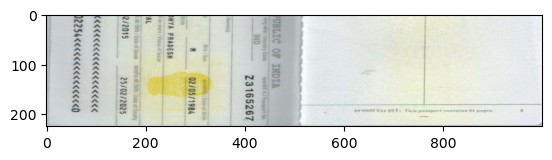

In [926]:
#show_image("image",cropped_image)

In [927]:

# initialize a rectangular and square structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
# smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
#show_image("Blackhat", blackhat)
#cv2.imshow("Blackhat", blackhat)

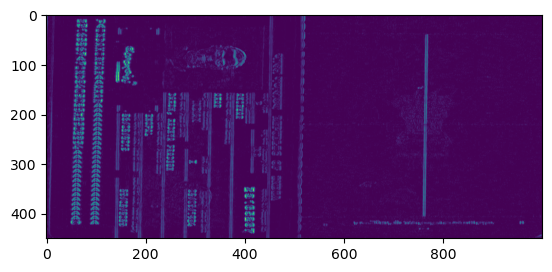

In [928]:
# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
show_image("Gradient", grad)
#cv2.imshow("Gradient", grad)

In [929]:
# apply a closing operation using the rectangular kernel to close
# gaps in between letters -- then apply Otsu's thresholding method
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255,
                       cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

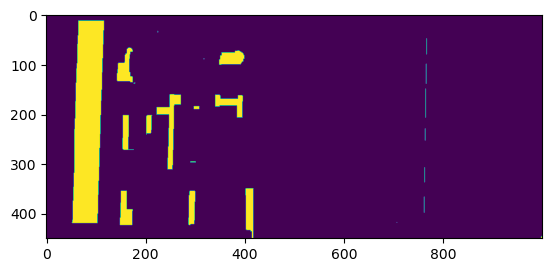

In [930]:
# perform another closing operation, this time using the square
# kernel to close gaps between lines of the MRZ, then perform a
# series of erosions to break apart connected components
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
thresh = cv2.erode(thresh, None, iterations=2)
show_image("Square Close",thresh)
#cv2.imshow("Square Close", thresh)

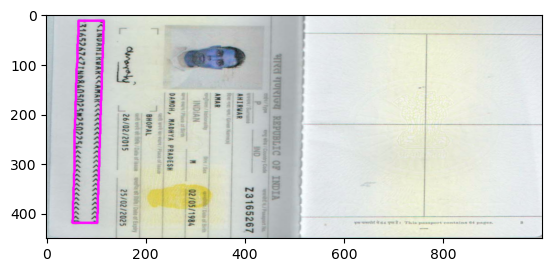

In [931]:
## DETERMINE CONTOURS AND FILTER THEM
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
 
#make a copy of the resized image since we are going to draw contours on the resized image
resizedImageCopy=np.copy(image)
 
# draw all contours with setting the parameter to -1
# but if you use this function, you should comment the for loop below
#cv2.drawContours(resizedImageCopy,contours,-1,(0,0,255),2)
#filter contours 
for i, c in enumerate(contours):
    areaContour=cv2.contourArea(c)
    if areaContour<2000 or 100000<areaContour:
        continue
    cv2.drawContours(resizedImageCopy,contours,i,(255,10,255),4)
     
# # display the original image with contours
# cv2.imshow('Image', resizedImageCopy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imwrite("resizedPartsContours.png", resizedImageCopy, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 
show_image("resizedPartsContours.png",resizedImageCopy)


In [932]:
# cnts = imutils.grab_contours(contours)
# cnts = sort_contours(contours, method="bottom-to-top")[0]
# # initialize the bounding box associated with the MRZ
mrzBox = None

In [933]:
# # find contours in the thresholded image and sort them from bottom
# # to top (since the MRZ will always be at the bottom of the passport)
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
#                         cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# cnts = sort_contours(cnts, method="bottom-to-top")[0]
# # initialize the bounding box associated with the MRZ
# mrzBox = None

In [934]:
# cnts

In [935]:
W,H

(1000, 450)

In [936]:
# # loop over the contours
# for i,c in enumerate(contours):
#     # compute the bounding box of the contour and then derive the
#     # how much of the image the bounding box occupies in terms of
#     # both width and height
#     (x, y, w, h) = cv2.boundingRect(c)
#     percentWidth = w / float(W)
#     percentHeight = h / float(H)
#     print("bbox=",(x, y, w, h))
#     print("contour=",c)
#     print("per width = ",percentWidth)
#     print("per height = ",percentHeight)
#     # if the bounding box occupies > 80% width and > 4% height of the
#     # image, then assume we have found the MRZ
#     if percentWidth > 0.1 and percentHeight > 0.003:
#         mrzBox = (x, y, w, h)
#         break
for c in contours:
    # compute the bounding box of the contour and use the contour to
    # compute the aspect ratio and coverage ratio of the bounding box
    # width to the width of the image
    (x, y, w, h) = cv2.boundingRect(c)
    areaContour=cv2.contourArea(c)
    print("area = ",areaContour)
    ar = w / float(h)
    crWidth = w / float(gray.shape[1])
    # check to see if the aspect ratio and coverage width are within
    # acceptable criteria
    if areaContour > 20000 : 

      # extract the ROI from the image and draw a bounding box
      # surrounding the MRZ
        #passport = image[y:y + h, x:x + w].copy()
        #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        mrzBox = (x, y, w, h)
        break

area =  2.5
area =  0.0
area =  0.0
area =  751.5
area =  1152.0
area =  1216.0
area =  0.0
area =  10.0
area =  0.0
area =  352.0
area =  755.5
area =  50.0
area =  1106.0
area =  1969.0
area =  0.0
area =  1.5
area =  0.0
area =  0.0
area =  1095.0
area =  1181.5
area =  0.0
area =  0.0
area =  20513.5


In [937]:
mrzBox

(52, 13, 65, 407)

In [938]:
# def check_bounding_box_position(image_width, image_height, bounding_box):
#     # Unpack the bounding box coordinates
#     x_min, y_min, x_max, y_max = bounding_box

#     # Calculate the center point of the bounding box
#     box_center_x = (x_min + x_max) / 2
#     box_center_y = (y_min + y_max) / 2

#     # Compare the box center coordinates with the image dimensions
#     if box_center_x < image_width / 2:
#         position = "Left"
#     elif box_center_x > image_width / 2:
#         position = "Right"
#     else:
#         position = "Center"

#     if box_center_y < image_height / 2:
#         position += "-Top"
#     elif box_center_y > image_height / 2:
#         position += "-Bottom"
#     else:
#         position += "-Center"

#     return position

In [939]:
def determine_bounding_box_side(x, y, w, h, image_width, image_height):
    # Calculate the center point of the bounding box
    center_x = x + (w / 2)
    center_y = y + (h / 2)

    # Calculate the image center coordinates
    image_center_x = image_width / 2
    image_center_y = image_height / 2

    # Determine the relative position of the bounding box center with respect to the image center
    if center_x < image_center_x and center_y < image_center_y:
        return "left"
    elif center_x > image_center_x and center_y < image_center_y:
        return "right"

    else:
        return "inside or overlapping multiple sides"

In [940]:
(x, y, w, h) = mrzBox

In [941]:
position = determine_bounding_box_side(x,y,w,h,W,H)

In [942]:
position

'left'

In [943]:

# if the MRZ was not found, exit the script
if mrzBox is None:
    print("[INFO] MRZ could not be found")
    sys.exit(0)
# pad the bounding box since we applied erosions and now need to
# re-grow it
(x, y, w, h) = mrzBox    
pX = int((x + w) * 0.03)
pY = int((y + h) * 0.03)
(x, y) = (x - pX, y - pY)
(w, h) = (w + (pX * 2), h + (pY * 2))
# extract the padded MRZ from the image
mrz = image[y:y + h, x:x + w]


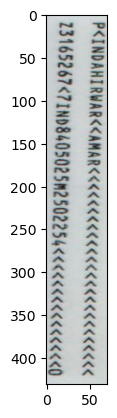

In [944]:
show_image("mrz",mrz)

In [945]:
if position=="left":
    mrz_rotated = cv2.rotate(mrz, cv2.ROTATE_90_COUNTERCLOCKWISE)
elif position=="right":
    mrz_rotated = cv2.rotate(mrz, cv2.ROTATE_90_CLOCKWISE)
elif position=="top":
    mrz_rotated = cv2.rotate(mrz, cv2.ROTATE_180)
else:
    mrz_rotated = mrz

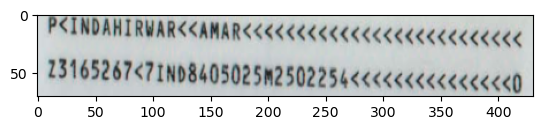

In [946]:
show_image("mrz",mrz_rotated)

In [947]:
mrzText = pytesseract.image_to_string(mrz_rotated)

In [948]:
mrzlist=mrzText.split('\n')[:-1]
mrzlist

['PCINDAHITRWARSSAMARK< KKK KK KKK KECKLER EKER ERK',
 '13165267<71ND&4OSOZSN2502254 <<< Kccecceecce)']

In [949]:
mrzlist

['PCINDAHITRWARSSAMARK< KKK KK KKK KECKLER EKER ERK',
 '13165267<71ND&4OSOZSN2502254 <<< Kccecceecce)']

In [631]:

def retreive_data(mrz_row_list):
#     print(mrz_row_list)
    detail_dict = {}
    line1_words = mrz_row_list[0].split("<")
    line2_words = mrz_row_list[1].split("<")
    detail_dict["Name"] = " ".join(line1_words[2:]) + " "+ line1_words[1][3:]
    detail_dict["country_code"] = line1_words[1][:3]
    detail_dict["pp_no"] = line2_words[0][:9]
    detail_dict["nationality"] = line2_words[0][10:13]
    #detail_dict["data_of_birth"] = datetime.strptime(line2_words[0][13:19], "%y%m%d").strftime("%d-%m-%y")
    detail_dict["data_of_birth"] = line2_words[0][13:19]
    detail_dict["gender"] = line2_words[0][20:21]
    #detail_dict["expiry_date"] = datetime.strptime(line2_words[0][21:27], "%d%m%y").strftime("%d-%m-%y")
    detail_dict["expiry_date"] = line2_words[0][21:27]
    return detail_dict
    

In [632]:
data = retreive_data(mrzlist)
# data

IndexError: list index out of range

In [ ]:
df = pd.DataFrame(data.items(),columns = ["Passport Key","Value"])

In [ ]:
df

In [ ]:
show_image("image",image)